In [51]:
using Revise
using EAMC
using Plots
using LinearAlgebra
using SparseArrays
using StatsBase

# utility functions
cg = cgrad(:matter, scale=:exp)
#cg.colors[1] = colorant"white"
#cg.values[2]=eps()

hm(x; kwargs...) = begin
    h = heatmap(x|>collect, yflip=true, color = cg; kwargs...)
    push!(myplots, h)
    h
end


hm (generic function with 1 method)

In [52]:
# experiment setup

beta = 2 # inverse temp / noise
period = 1 # forcing period
force = 2 # forcing amplitude
phi = 1 # time scaling
tmax = period * 4 # time

nx = 5
nt = round(Int, tmax / period * 4)

x0 = 2

ts = range(0, tmax, length=nt+1)
xmax = 1.5
xs = range(-xmax,xmax, length=nx)


process = EAMC.OverdampedLangevin(
    V = (x,t) -> beta * (x^2-1)^2 + force * sin(t / period * 2 * pi) * x,
    phi = phi,
    grid = xs)

qs = [EAMC.generatormatrix(process, t) for t in ts];

myplots = [];

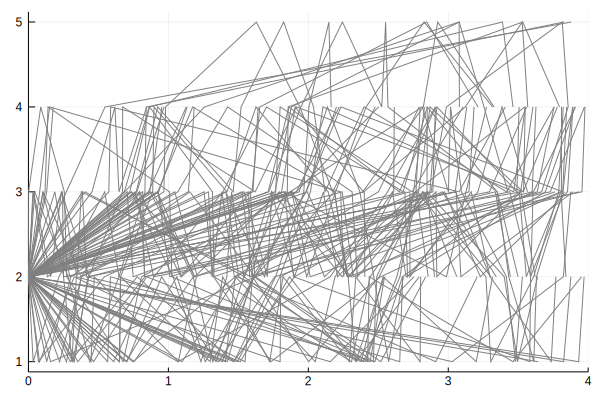

In [53]:
p=plot(legend=false)
for i=1:100
plot!(EAMC.gillespie(qs, ts, x0, tmax), xlims=(0, tmax), color=:grey)
end; p

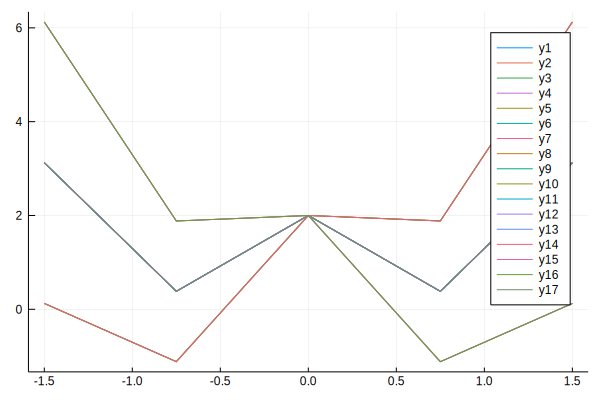

In [54]:
plot(xs, [x->process.V(x,t) for t in ts])

In [55]:
g = galerkin(qs, ts);

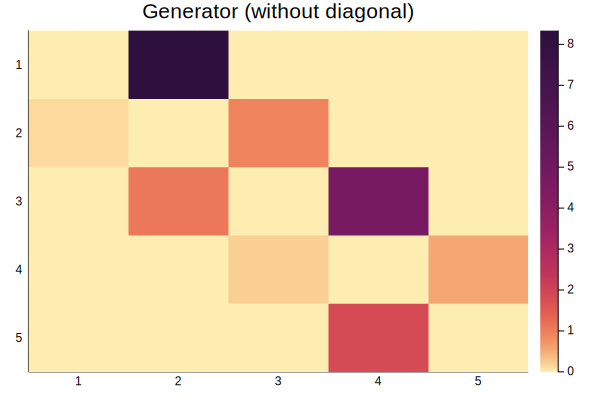

In [56]:
let q = qs[4]
    hm(q-Diagonal(q), title="Generator (without diagonal)")
end

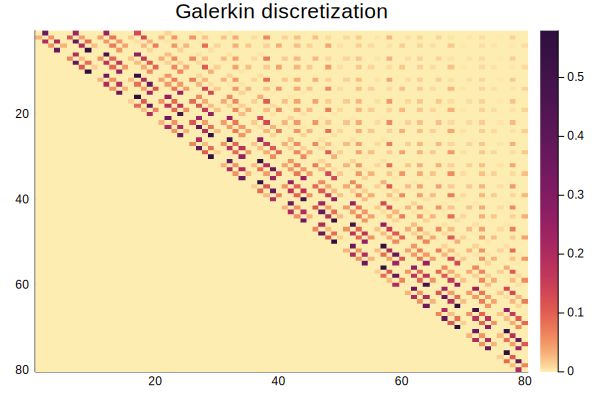

In [57]:
hm(g, color=cg, title="Galerkin discretization")

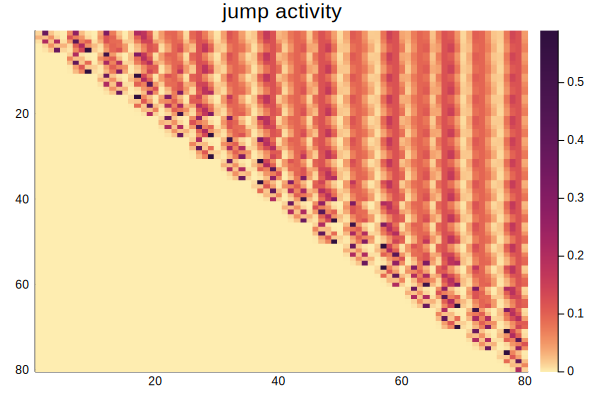

In [58]:
E = EAMC.jumpactivity(g)
hm(E, title="jump activity")

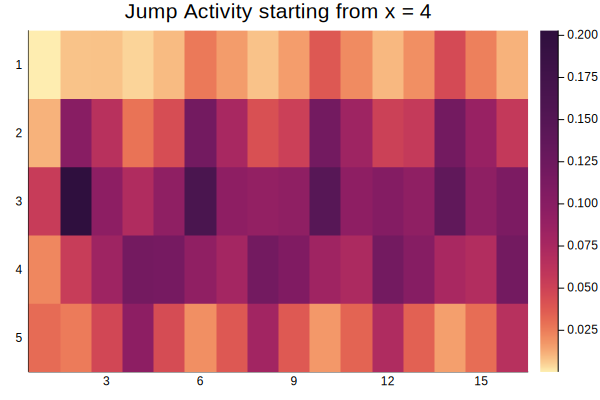

In [59]:
f0=zeros(nx)
x0 = 4
f0[x0] = 1
act = EAMC.project_jumpactivity(E, f0)
hm(act, title="Jump Activity starting from x = $x0")

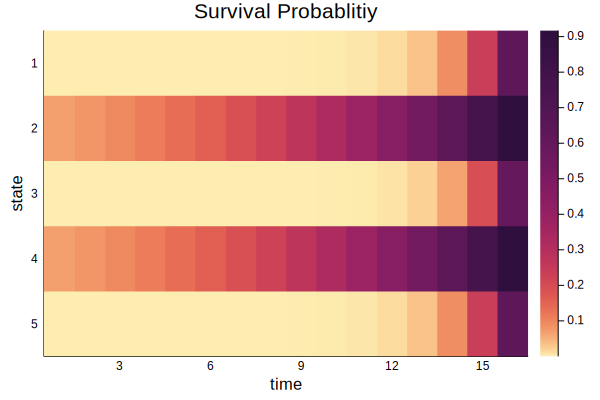

In [60]:
#survival from inside each timecell to T
qout = [collect(-diag(q)) for q in qs]
q = qout[1]
i = 4
S=zeros(nx, nt)
for i=1:nt
    S[:,i] .= 1 ./ q .*(exp.(-q*(ts[end] - ts[i+1])) - exp.(-q*(ts[end] - ts[i]))) / (ts[i+1]-ts[i])
end
hm(S, title="Survival Probablitiy", xlabel="time", ylabel="state")

In [61]:
Pf = EAMC.perronfrobenius(g, qs, ts)

5×5 Adjoint{Float64,Array{Float64,2}}:
 0.0427342  0.0419567  0.0364862  0.0274729  0.0263091
 0.523582   0.520136   0.465066   0.37528    0.363746 
 0.0969189  0.0961889  0.0915733  0.0838942  0.0828998
 0.378552   0.386344   0.434814   0.523991   0.507618 
 0.0474347  0.0487642  0.0571999  0.0712468  0.073059 

In [62]:
Pf_exp = exp(qs[1]|>collect)'

5×5 Adjoint{Float64,Array{Float64,2}}:
 0.0666217   0.0488732   0.0259866  0.00585624  0.00388378
 0.758556    0.736137    0.42771    0.124252    0.0908941 
 0.0800445   0.0848817   0.0926063  0.0848817   0.0800445 
 0.0908941   0.124252    0.42771    0.736137    0.758556  
 0.00388378  0.00585624  0.0259866  0.0488732   0.0666217 

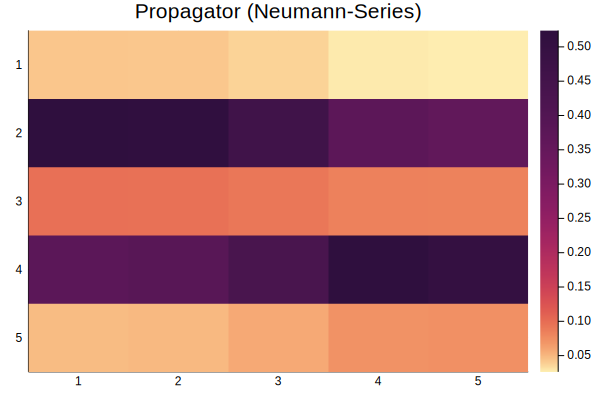

In [63]:
hm(Pf, title="Propagator (Neumann-Series)")

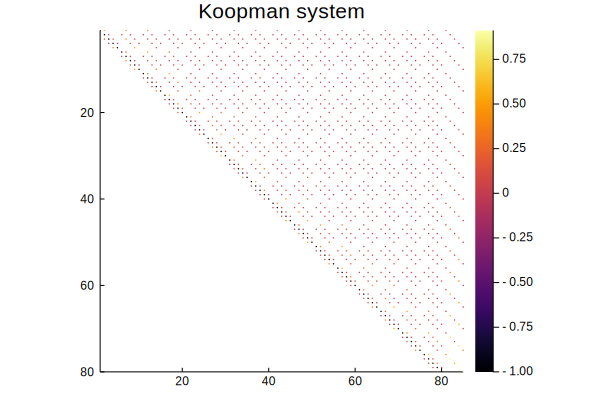

In [64]:
A = EAMC.koopman_system(g, nx)
spy(A, title="Koopman system")

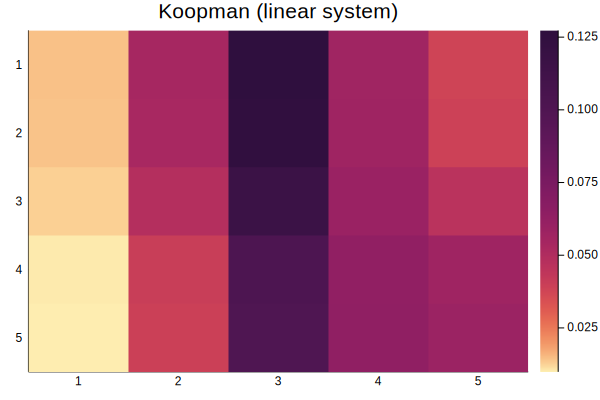

In [65]:
K = EAMC.koopman(g, nx)
hm(K, title="Koopman (linear system)")

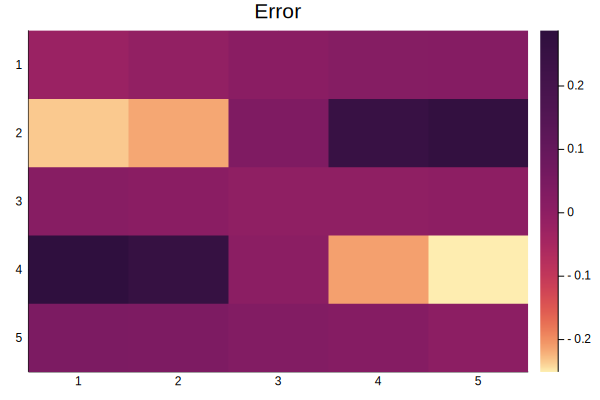

In [66]:
hm(Pf - Pf_exp, title="Error")

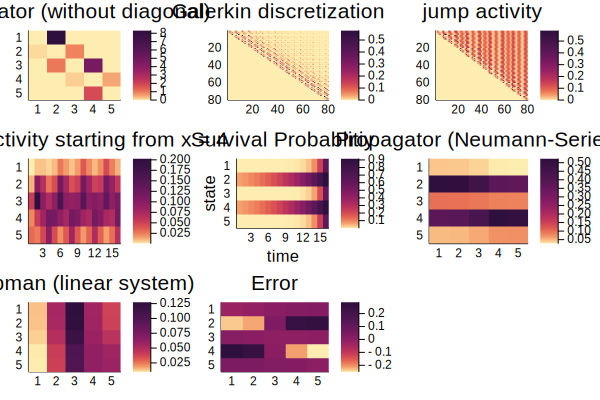

In [67]:
gr()
plot(myplots...)